In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.impute import SimpleImputer

data_uni_2 = pd.read_csv("data_uni.csv")

data_uni_2.iloc[:, [24,25,29]]= data_uni_2.iloc[:, [24,25,29]].fillna(0)
column_miss= list(data_uni_2.columns[data_uni_2.isnull().any()])

# IMPUTER ===========================================================================

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

data_uni_2[column_miss]= imputer.fit_transform(data_uni_2[column_miss])

data_uni_2= data_uni_2.drop(["Course","AWM year 1", "AWM year 2", "AWM year 3", "Overall AWM"], axis = 1)

# FORMATING MANUALLY ================================================================

#ethinicty binarisation 
data_uni_2.Ethnicity = data_uni_2.Ethnicity.str.replace("White", "0")
data_uni_2.Ethnicity = data_uni_2.Ethnicity.str.replace("Asian", "1")
data_uni_2.Ethnicity = data_uni_2.Ethnicity.str.replace("Black/Black British African", "1")
data_uni_2.Ethnicity = data_uni_2.Ethnicity.str.replace("Other ethnic background", "1")

# Polar 4 Score Binarisation
data_uni_2.Polar_4_Score = data_uni_2.Polar_4_Score.replace(5, 0)
data_uni_2.Polar_4_Score = data_uni_2.Polar_4_Score.replace(4, 0)
data_uni_2.Polar_4_Score = data_uni_2.Polar_4_Score.replace(3, 0)
data_uni_2.Polar_4_Score = data_uni_2.Polar_4_Score.replace(2, 1)

#splitting X and y ==================================================================
y = data_uni_2["desertion"]
X = data_uni_2.drop(["desertion"], axis = 1)


### Categorical and numeric features

In [3]:
X.columns

Index(['UCAS', '25 Above', 'Disability', 'Ethnicity', 'Gender', 'British',
       'English native Language', 'Parent He attendance', 'Polar_4_Score',
       'SLC', 'Care Leaver', 'Student Visa', 'Refugee',
       'London Permanent Residence', 'UCAS Points', 'English', 'Maths',
       'A Levels', 'Btec', 'Previous work', 'Bursary', 'Attendance',
       'Progression', 'First Sit', 'Second Sit', 'Fails', 'No Submissions',
       'Late Submission', 'Pass', 'Re Takes'],
      dtype='object')

In [4]:
fe_num= ['UCAS Points', 'English', 'Maths', 'Attendance', 'First Sit', 
         'Second Sit', 'Fails', 'No Submissions', 'Late Submission',
        'Pass']

In [5]:
fe_cat= ['UCAS', '25 Above', 'Disability', 'Ethnicity', 'Gender',
       'British', 'English native Language', 'Parent He attendance',
       'Polar_4_Score', 'SLC', 'Care Leaver', 'Student Visa', 'Refugee',
       'London Permanent Residence', 'A Levels', 'Btec', 'Previous work', 'Bursary',
        'Progression', 'Re Takes']

## Scaling

In [6]:
# we are going to scale just the continous ones which are
fe_num_cont= ['UCAS Points', 'Attendance', 'Pass']

# let the following without changes
fe_num_no= ['English','Maths', 'First Sit', 'Second Sit', 'Fails', 'No Submissions', 'Late Submission']

In [7]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

x_num_cont= pd.DataFrame(sc.fit_transform(X[fe_num_cont]))
x_num_cont.columns= X[fe_num_cont].columns
#x_num_cont

In [8]:
X_num = pd.concat((x_num_cont, X[fe_num_no]), axis =1)
#X_num

## OneHotEncoder

In [9]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown= "error", sparse = False, drop = "if_binary")
X_cat = pd.DataFrame(enc.fit_transform(X[fe_cat]))
X_cat.columns= enc.get_feature_names_out()
#X_cat

In [10]:
x_num_cat= pd.concat((X_num, X_cat), axis =1)
#x_num_cat

## y encoder

In [11]:
#Encoding dependent Variable
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_enc = le.fit_transform(y)
y_enc= pd.DataFrame(y_enc, columns=["desertion"])
#y_enc

In [12]:
y_enc

,desertion
0,0
1,1
2,1
3,1
4,0
...,...
1028,1
1029,0
1030,1
1031,0


# SMOTE

In [13]:
from imblearn.over_sampling import SMOTE
from collections import Counter

sm = SMOTE(random_state=42)
x_res, y_res = sm.fit_resample(x_num_cat, y_enc)

In [14]:
y_res.value_counts()

desertion
0            875
1            875
dtype: int64

In [15]:
x_res.columns

Index(['UCAS Points', 'Attendance', 'Pass', 'English', 'Maths', 'First Sit',
       'Second Sit', 'Fails', 'No Submissions', 'Late Submission', 'UCAS_yes',
       '25 Above_yes', 'Disability_yes', 'Ethnicity_1', 'Gender_Male',
       'British_yes', 'English native Language_yes', 'Parent He attendance_NO',
       'Parent He attendance_no', 'Parent He attendance_yes',
       'Polar_4_Score_1.0', 'SLC_yes', 'Care Leaver_yes', 'Student Visa_yes',
       'Refugee_yes', 'London Permanent Residence_yes', 'A Levels_yes',
       'Btec_yes', 'Previous work_yes', 'Bursary_yes', 'Progression_yes',
       'Re Takes_yes'],
      dtype='object')

# Feature Selection

In [16]:
data_prepro= pd.concat((x_res, y_res), axis =1)
data_prepro

,UCAS Points,Attendance,Pass,English,Maths,First Sit,Second Sit,Fails,No Submissions,Late Submission,...,Student Visa_yes,Refugee_yes,London Permanent Residence_yes,A Levels_yes,Btec_yes,Previous work_yes,Bursary_yes,Progression_yes,Re Takes_yes,desertion
0,-0.524646,0.693727,0.420941,5.0,4.0,3,3.000000,0,2,2,...,1.0,0.0,1.000000,1.000000,0.000000,1.0,0.000000,1.0,1.0,0
1,-0.373711,-1.276930,-0.423655,5.0,5.0,1,2.000000,5,3,0,...,0.0,0.0,0.000000,1.000000,0.000000,1.0,1.000000,0.0,0.0,1
2,1.035022,-1.149791,0.420941,4.0,4.0,6,0.000000,0,0,0,...,0.0,0.0,1.000000,1.000000,0.000000,1.0,0.000000,1.0,0.0,1
3,0.079096,-1.721917,0.420941,9.0,8.0,6,0.000000,0,0,0,...,0.0,0.0,1.000000,1.000000,0.000000,1.0,0.000000,1.0,0.0,1
4,1.085334,0.503018,0.420941,6.0,5.0,4,2.000000,0,2,0,...,0.0,0.0,1.000000,1.000000,0.000000,1.0,0.000000,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1745,-0.597912,-1.298534,0.420941,6.0,5.135944,4,2.000000,0,0,0,...,0.0,0.0,1.000000,1.000000,0.000000,0.0,0.000000,1.0,0.0,1
1746,0.579690,-0.991664,0.420941,3.10251,2.205019,6,0.000000,0,0,0,...,0.0,0.0,0.897490,0.102510,0.897490,1.0,0.000000,1.0,0.0,1
1747,0.383907,-1.749849,-2.112847,3.937228,4.937228,4,1.874457,3,1,0,...,0.0,0.0,0.000000,0.062772,1.000000,1.0,0.937228,0.0,0.0,1
1748,-1.179011,-1.145744,-2.112847,5.312114,4.687886,2,1.000000,3,1,0,...,0.0,0.0,1.000000,1.000000,0.000000,0.0,0.000000,0.0,0.0,1


Imported 0.1.991 version. Select nrows to a small number when running on huge datasets.
output = featurewiz(dataname, target, corr_limit=0.70, verbose=2, sep=',', 
		header=0, test_data='',feature_engg='', category_encoders='',
		dask_xgboost_flag=False, nrows=None)
Create new features via 'feature_engg' flag : ['interactions','groupby','target']

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
    Shape of your Data Set loaded: (1750, 33)
    Loaded train data. Shape = (1750, 33)
    Some column names had special characters which wer

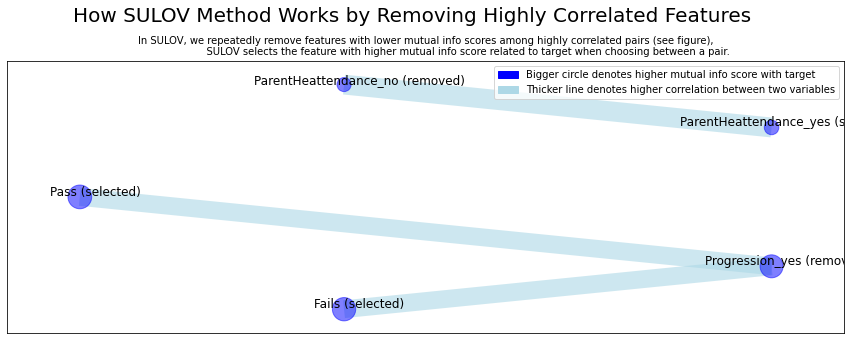

Time taken for SULOV method = 0 seconds
    Adding 0 categorical variables to reduced numeric variables  of 28
Final list of selected vars after SULOV = 28
Readying dataset for Recursive XGBoost by converting all features to numeric...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Current number of predictors = 28 
    XGBoost version using 1.6.2 as tree method: hist
Number of booster rounds = 100
        using 28 variables...
            Time taken for regular XGBoost feature selection = 0 seconds
        using 22 variables...
            Time taken for regular XGBoost feature selection = 0 seconds
        using 16 variables...
            Time taken for regular XGBoost feature selection = 0 seconds
        using 10 variables...
            Time

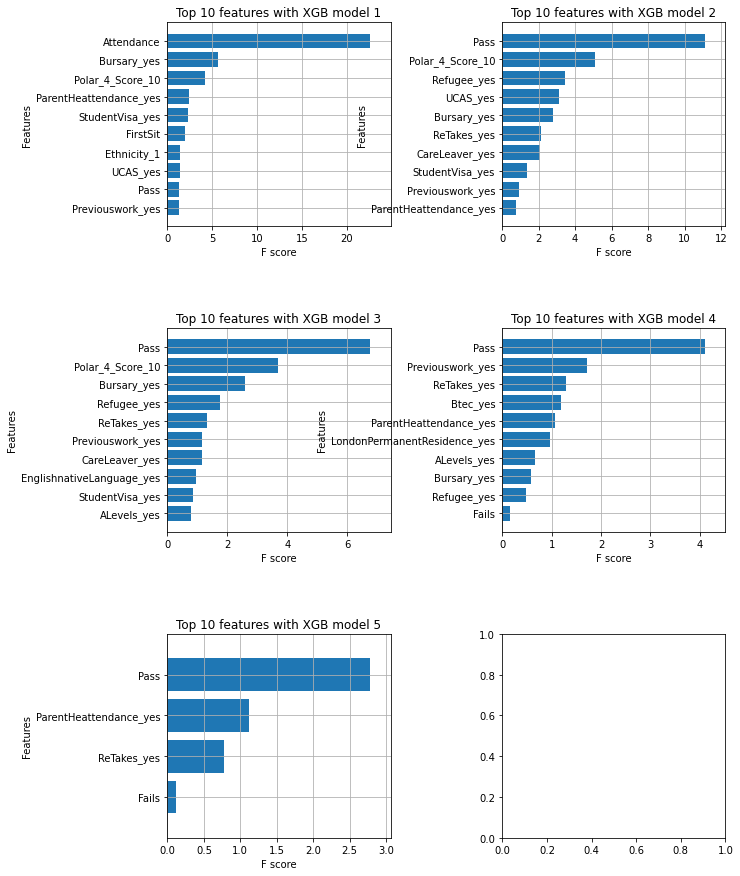

    Completed XGBoost feature selection in 1 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 18 important features:
['Attendance', 'Bursary_yes', 'Polar_4_Score_10', 'ParentHeattendance_yes', 'StudentVisa_yes', 'FirstSit', 'Ethnicity_1', 'UCAS_yes', 'Pass', 'Previouswork_yes', 'Refugee_yes', 'ReTakes_yes', 'CareLeaver_yes', 'EnglishnativeLanguage_yes', 'ALevels_yes', 'Btec_yes', 'LondonPermanentResidence_yes', 'Fails']
Total Time taken for featurewiz selection = 2 seconds
Output contains a list of 18 important features and a train dataframe


In [17]:
from featurewiz import featurewiz

target = "desertion" 

features, data_full = featurewiz(data_prepro, target, corr_limit=0.8, verbose =2, sep=",", header= 0, test_data= 2, feature_engg= "", category_encoders="")

In [18]:
X= data_full.drop(["desertion"], axis = 1)
y= data_full['desertion']

# Models

We are gonna use the features selected by featurewiz 
1. cross validation 
2. train test split 

# 1. Cross Validation

In [19]:
from sklearn.model_selection import cross_val_predict

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [21]:
def resume_m(y_real, y_pred, model):
    
    metrics= []
    
    metrics.append(accuracy_score(y_real, y_pred))   #acc
    metrics.append(roc_auc_score(y_real, y_pred))    # auc
    metrics.append(recall_score(y_real, y_pred))     #recall
    metrics.append(precision_score(y_real, y_pred))  #precision
    metrics.append(f1_score(y_real, y_pred))         #f1
    
    
    g= pd.DataFrame(metrics).T
    g.columns= ['Accuracy', 'AUC', 'Recall', 'Precision', 'F1']
    
    g= g.set_axis([model], axis='index')
    
    return g


## Plot Functions

In [22]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay


def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)     

In [23]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type)
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

## Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier

rf= RandomForestClassifier()
rf_y_pred = cross_val_predict(rf, X, y, cv=10)

In [25]:
rf_metrics=resume_m(y, rf_y_pred, "RandomForest")
rf_metrics

,Accuracy,AUC,Recall,Precision,F1
RandomForest,0.981714,0.981714,0.981714,0.981714,0.981714


In [26]:
fpr, tpr, thresholds = roc_curve(y, rf_y_pred)

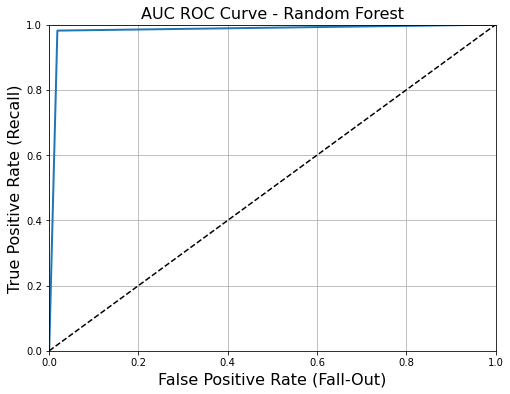

In [27]:
plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr, label="Random Forest")
plt.title("AUC ROC Curve - Random Forest", fontsize=16)
plt.show()

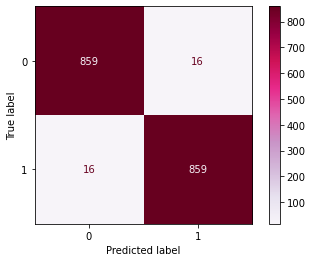

In [28]:
ConfusionMatrixDisplay.from_predictions(y, rf_y_pred, cmap= 'PuRd')
plt.show()

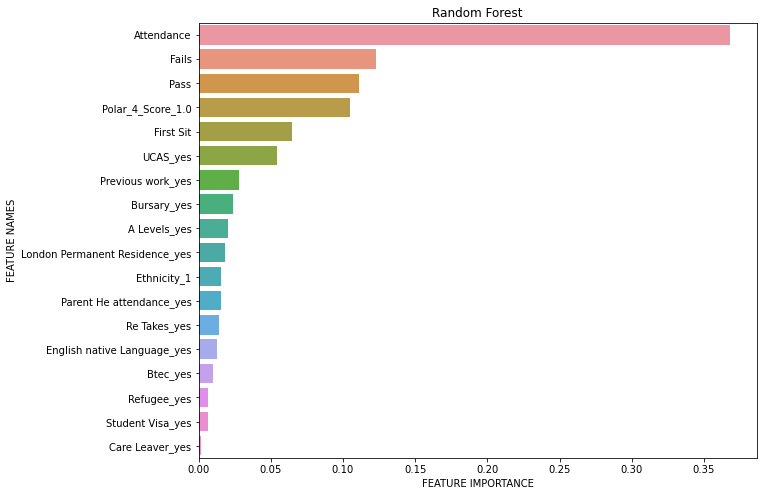

In [29]:
rf.fit(X,y)
plot_feature_importance(rf.feature_importances_, X.columns, "Random Forest")

## Gradient Boosting 

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

gboc= GradientBoostingClassifier()
gboc_y_pred = cross_val_predict(gboc, X, y, cv=10)

In [31]:
gboc_metrics=resume_m(y, gboc_y_pred, "Gradient Boosting")
gboc_metrics

,Accuracy,AUC,Recall,Precision,F1
Gradient Boosting,0.977714,0.977714,0.971429,0.983796,0.977573


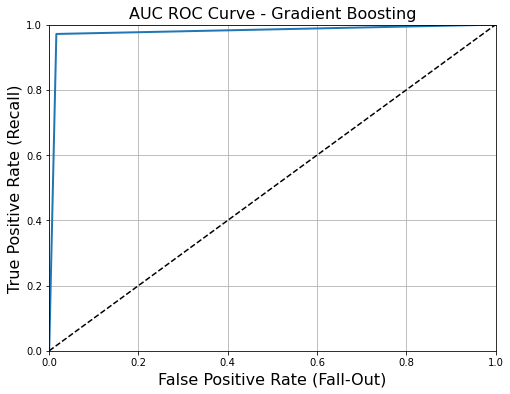

In [32]:
fpr, tpr, thresholds = roc_curve(y, gboc_y_pred)

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr, label="Gradient Boosting")
plt.title("AUC ROC Curve - Gradient Boosting", fontsize=16)
plt.show()

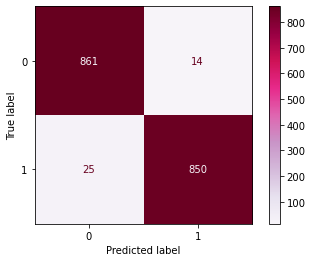

In [33]:
ConfusionMatrixDisplay.from_predictions(y, gboc_y_pred, cmap= 'PuRd')
plt.show()

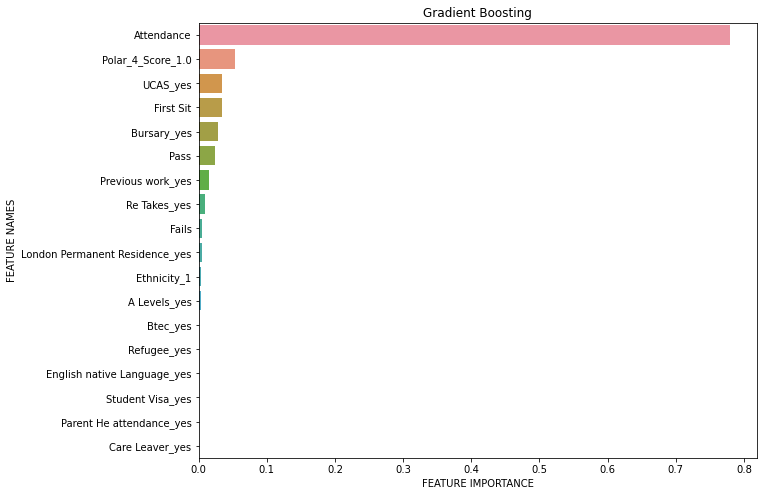

In [34]:
gboc.fit(X,y)
plot_feature_importance(gboc.feature_importances_, X.columns, "Gradient Boosting")

## AdaBoost

In [35]:
from sklearn.ensemble import AdaBoostClassifier

ada= AdaBoostClassifier(random_state=42)
ada_y_pred= cross_val_predict(ada, X, y, cv=10)

In [36]:
ada_metrics=resume_m(y, ada_y_pred, "AdaBoostClassifier")
ada_metrics

,Accuracy,AUC,Recall,Precision,F1
AdaBoostClassifier,0.971429,0.971429,0.966857,0.975779,0.971297


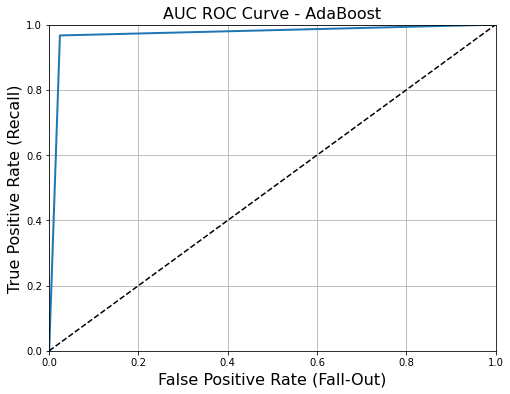

In [37]:
fpr, tpr, thresholds = roc_curve(y, ada_y_pred)

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr, label="AdaBoost")
plt.title("AUC ROC Curve - AdaBoost", fontsize=16)
plt.show()

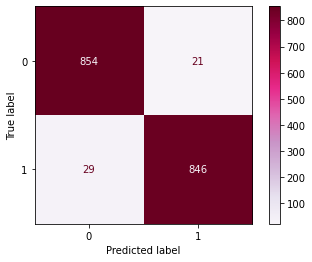

In [38]:
ConfusionMatrixDisplay.from_predictions(y, ada_y_pred, cmap= 'PuRd')
plt.show()

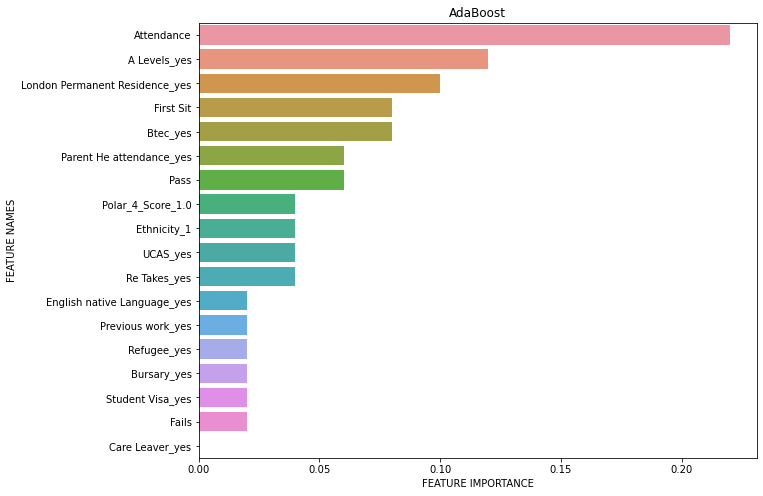

In [39]:
ada.fit(X,y)
plot_feature_importance(ada.feature_importances_, X.columns, "AdaBoost")

# RESUME OF THE EXPERIMENT

In [40]:
resum= pd.concat((ada_metrics, gboc_metrics),axis =0)
resum= pd.concat((resum, rf_metrics),axis =0)
resum

,Accuracy,AUC,Recall,Precision,F1
AdaBoostClassifier,0.971429,0.971429,0.966857,0.975779,0.971297
Gradient Boosting,0.977714,0.977714,0.971429,0.983796,0.977573
RandomForest,0.981714,0.981714,0.981714,0.981714,0.981714
